# Forecasting with Multi-Layer Preception (MLP)

Data yang digunakan adalah data Store Item Demand Forecasting Challenge yang bersumber dari Kaggle (https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv) dengan atribut yang digunakan diantaranya:
* date - Date of the sale data. There are no holiday effects or store closures.
* store - Store ID
* item - Item ID
* sales - Number of items sold at a particular store on a particular date.

# Import Package

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import  iplot
# Import the necessaries libraries
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = 'iframe'
%matplotlib inline
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
# from tensorflow import set_random_seed
from numpy.random import seed
# set_random_seed(1)
seed(1)

# Loading Data

In [2]:
train = pd.read_csv(r"D:\My Skill\Data Science\MLP\train.csv", parse_dates=['date'])
test = pd.read_csv("D:\My Skill\Data Science\MLP\Salinan test.csv", parse_dates=['date'])

In [3]:
train

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [5]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


Data di atas adalah dataset penjualan yang mencakup beberapa informasi penting mengenai penjualan barang di sebuah toko dalam rentang waktu [2013-2017]. Berikut adalah penjelasan dari masing-masing kolom dalam data tersebut:
* date: Kolom ini mencatat tanggal terjadinya penjualan. Format yang digunakan adalah tahun-bulan-tanggal (YYYY-MM-DD).
* store: Kolom ini menunjukkan identifikasi toko tempat penjualan terjadi. Dalam contoh ini, nilai yang ada adalah '1', yang berarti semua penjualan terjadi di toko 1.
* item: Kolom ini menunjukkan identifikasi item atau barang yang dijual. Dalam contoh ini, nilai yang ada adalah '1', yang berarti semua data merujuk pada penjualan item 1.
* sales: Kolom ini mencatat jumlah unit yang terjual pada tanggal tertentu di toko tersebut untuk item tersebut. Nilai-nilai yang diberikan menunjukkan jumlah penjualan harian untuk item 1 di toko 1.

## Melihat selisih antara data train dan test

In [6]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


Prediksi yang akan dilakukan untuk 90 hari ke depan.

In [7]:
# Membuat DataFrame dengan informasi statistik tentang dataset 'train'
pd.DataFrame({
    "type": train.dtypes.values,  # Tipe data untuk setiap kolom
    "null": train.isnull().sum().values,  # Jumlah nilai null untuk setiap kolom
    "null_percentage": ["{:.2f}%".format(val) for val in train.isnull().sum().values / len(train) * 100],  # Persentase nilai null untuk setiap kolom
    "unique": [train[i].nunique() for i in train.columns],  # Jumlah nilai unik untuk setiap kolom
    "duplicated": train.duplicated().sum(),  # Jumlah baris yang terduplikat dalam dataset
    "sample": [list(pd.Series(train.dropna()[i].unique()).sample())[0] for i in train.columns]  # Salah satu nilai acak dari setiap kolom (setelah menghapus nilai null)
}).set_index(train.isnull().sum().index).sort_values("null", ascending=False)

type  null null_percentage  unique  duplicated  \
date   datetime64[ns]     0           0.00%    1826           0   
store           int64     0           0.00%      10           0   
item            int64     0           0.00%      50           0   
sales           int64     0           0.00%     213           0   

                    sample  
date   2013-09-16 00:00:00  
store                    1  
item                    25  
sales                   16

Data tersebut tidak terdapat missing value ataupun duplikat sehingga bisa digunakan untuk tahapan selanjutnya.

# Exploratory Data Analysis

In [8]:
# Analisis Deskriptif
train.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

Dataset ini mencakup 913.000 observasi yang mencatat penjualan item di berbagai store. Terdapat 10 store yang berbeda, dan masing-masing menjual hingga 50 jenis item. Rata-rata penjualan per hari untuk setiap item adalah sekitar 52 unit, dengan variasi yang cukup besar di mana standar deviasinya mencapai 28,80 unit. Penjualan terendah yang tercatat adalah 0 unit, sementara penjualan tertinggi mencapai 231 unit. Data ini mencerminkan adanya variasi yang signifikan dalam jumlah penjualan harian di berbagai toko dan item, yang dapat memberikan wawasan penting untuk analisis lebih lanjut mengenai tren penjualan dan perencanaan bisnis.

In [9]:
# Mengelompokkan dan menjumlahkan penjualan harian berdasarkan tanggal
daily_sales = train.groupby('date', as_index=False)['sales'].sum()

# Mengelompokkan dan menjumlahkan penjualan harian berdasarkan toko dan tanggal
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()

# Mengelompokkan dan menjumlahkan penjualan harian berdasarkan item dan tanggal
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

# Penjualan per Hari

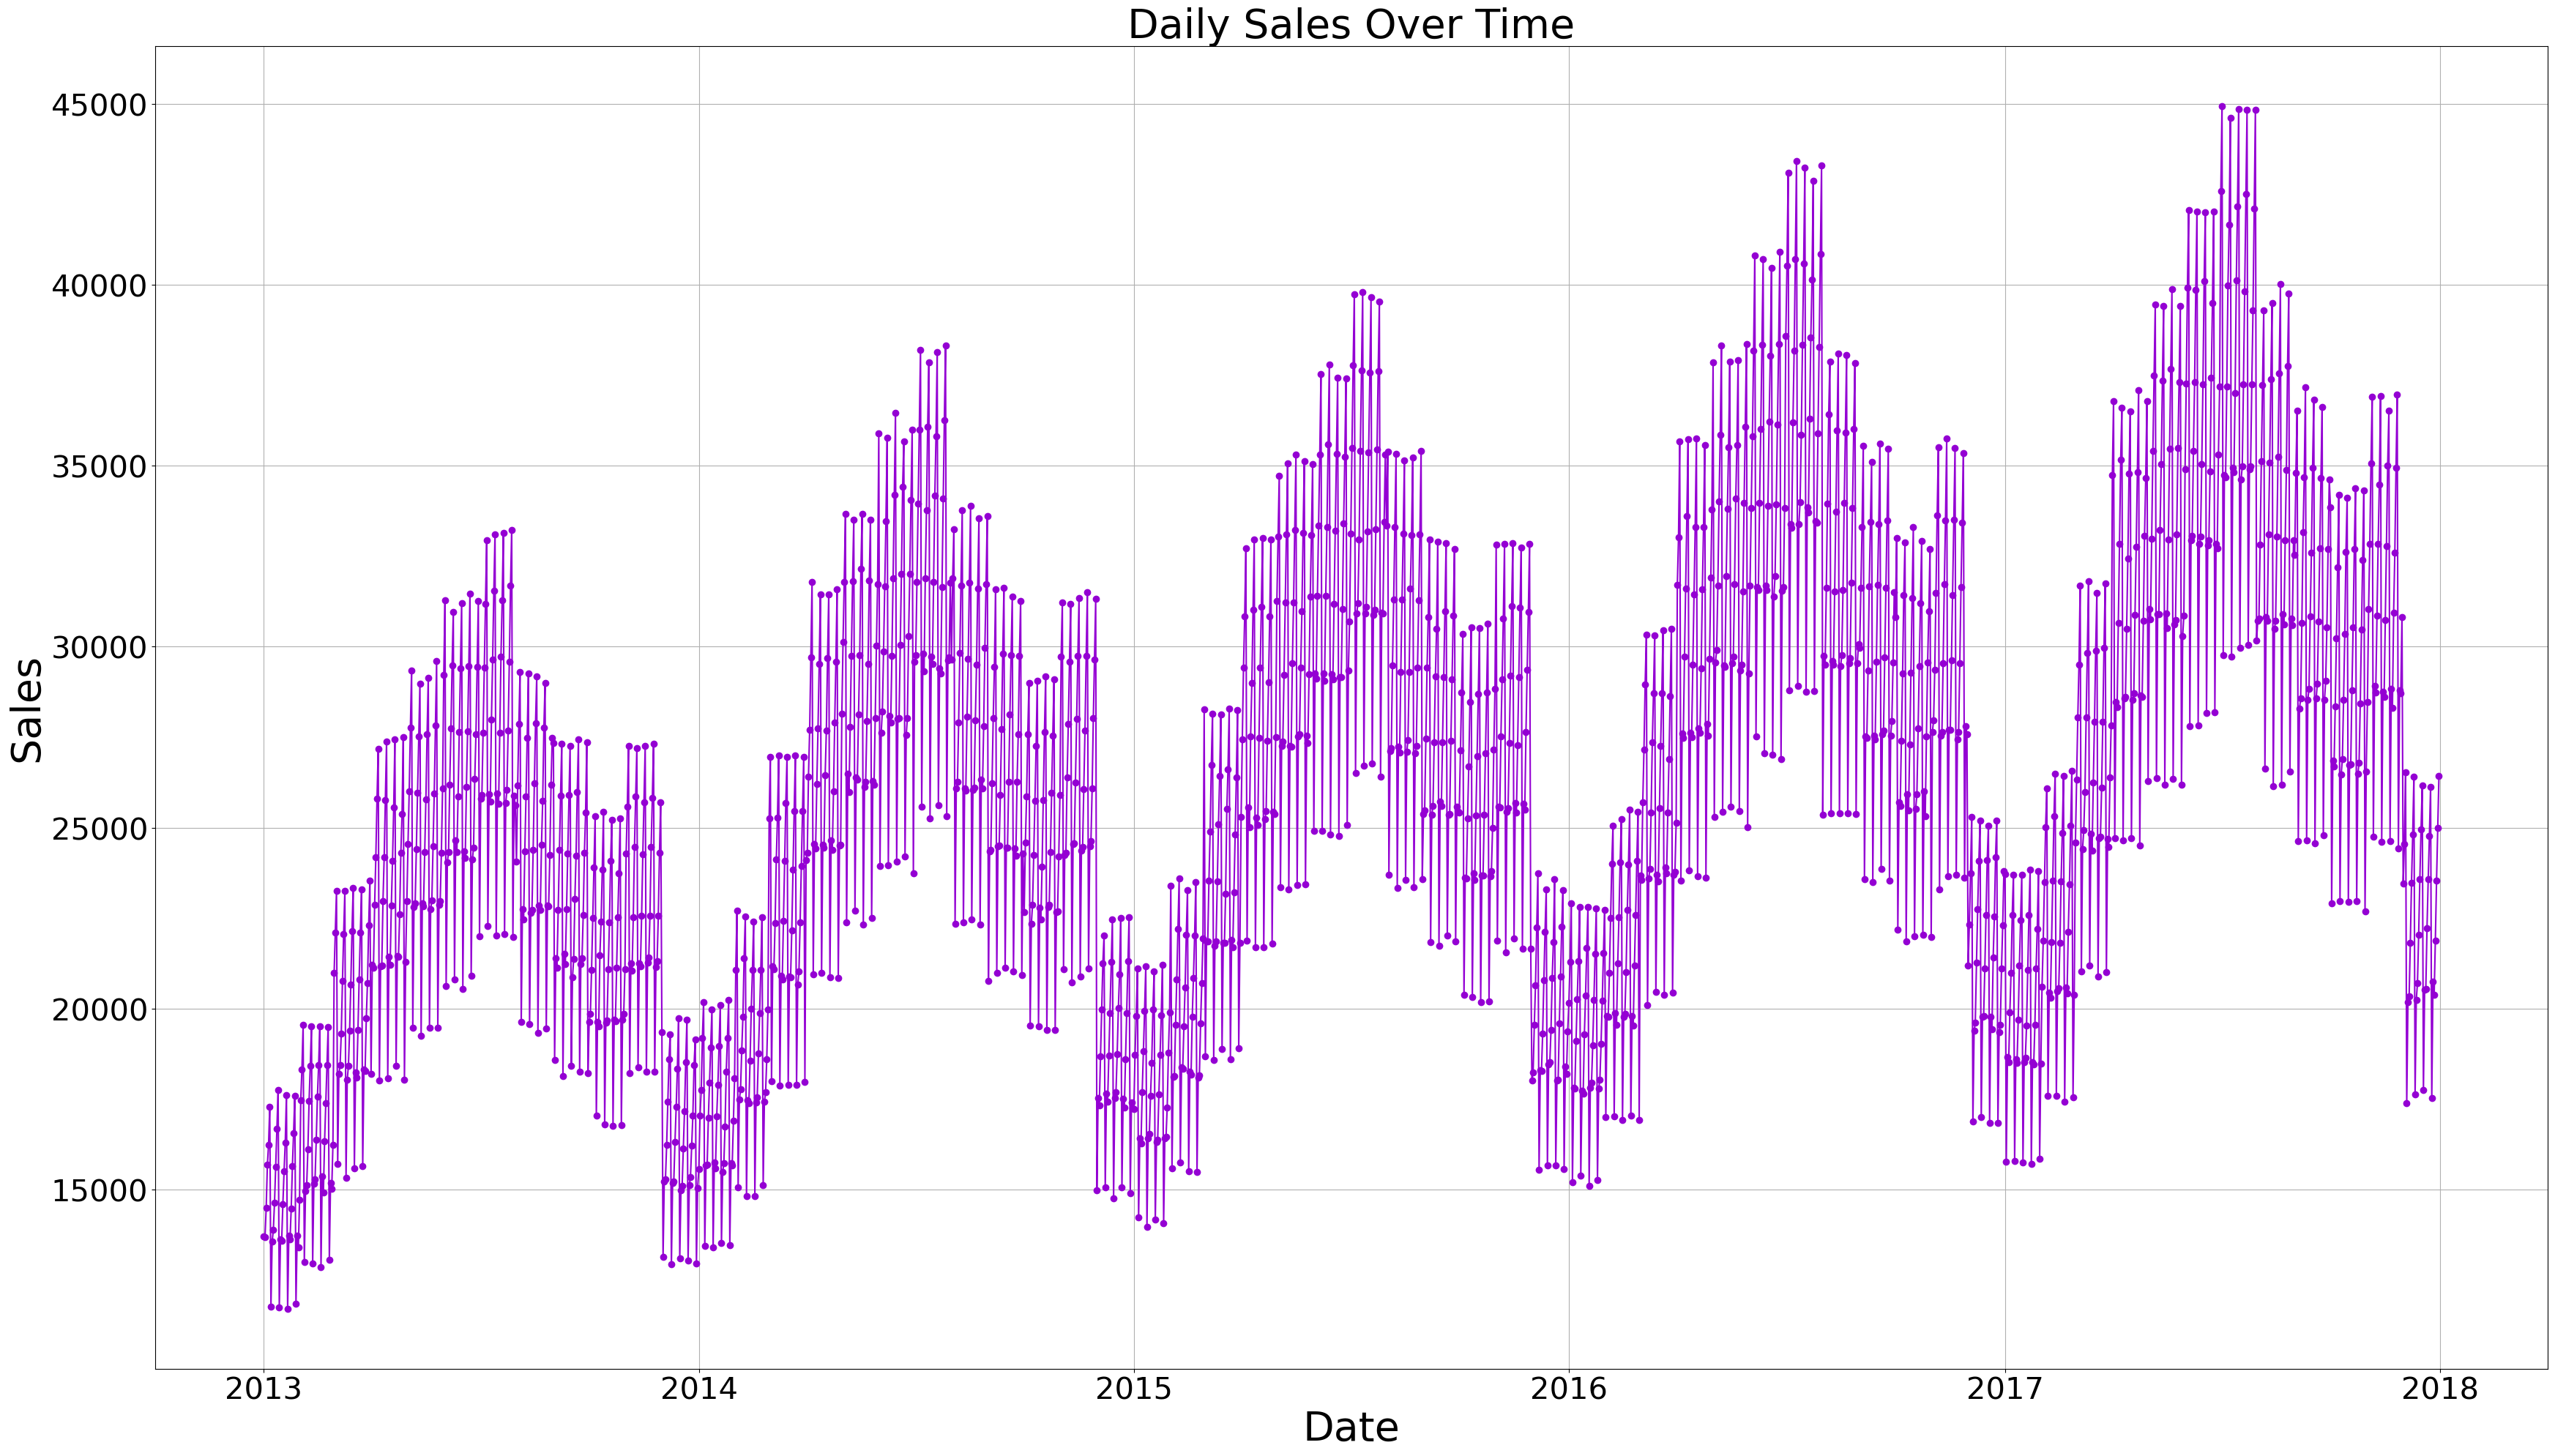

In [10]:
# Membuat grafik garis
plt.figure(figsize=(35, 20))
plt.plot(daily_sales['date'], daily_sales['sales'], marker='o', color='darkviolet')
plt.title('Daily Sales Over Time', fontsize=40)
plt.xlabel('Date', fontsize=40)
plt.ylabel('Sales', fontsize=40)
plt.xticks(rotation=0, fontsize=30)
plt.yticks(rotation=0, fontsize=30)
plt.grid(True)
plt.tight_layout()  # Menyesuaikan tata letak agar tidak ada label yang terpotong
plt.show()

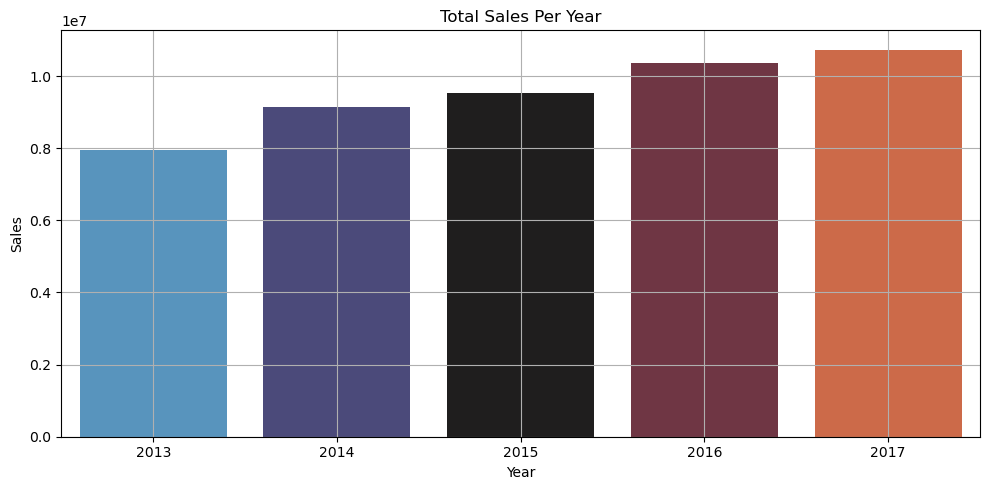

In [11]:
# Pastikan kolom 'date' dalam format datetime
train['date'] = pd.to_datetime(train['date'])

# Ekstrak tahun dari kolom 'date'
train['year'] = train['date'].dt.year

# Kelompokkan data berdasarkan tahun dan hitung total penjualan per tahun
yearly_sales = train.groupby('year', as_index=False)['sales'].sum()

# Membuat bar plot menggunakan seaborn dengan warna spesifik
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='sales', data=yearly_sales, palette='icefire')
plt.title('Total Sales Per Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.xticks(rotation=0)  # Memutar label sumbu x agar lebih mudah dibaca
plt.grid(True)
plt.tight_layout()  # Menyesuaikan tata letak agar tidak ada label yang terpotong
plt.show()

Dari kedua plot di atas, dapat diketahui bahwa tren penjualan dari tahun ke tahun mengalami kenaikan secara bertahap. Selain itu grafik tersebut terdapat tren penjualan di mana penjualan mengalami kenaikan bertahap di awal tahun sampai dengan pertengahan tahun. Namun, setelah mencapai puncak, penjualan mengalami penurun secara bertahap hingga akhir tahun dan mengelami kenaikan bertahap di awal tahun. Tren tersebut terjadi di setiap tahunnya dari 2013-2017.

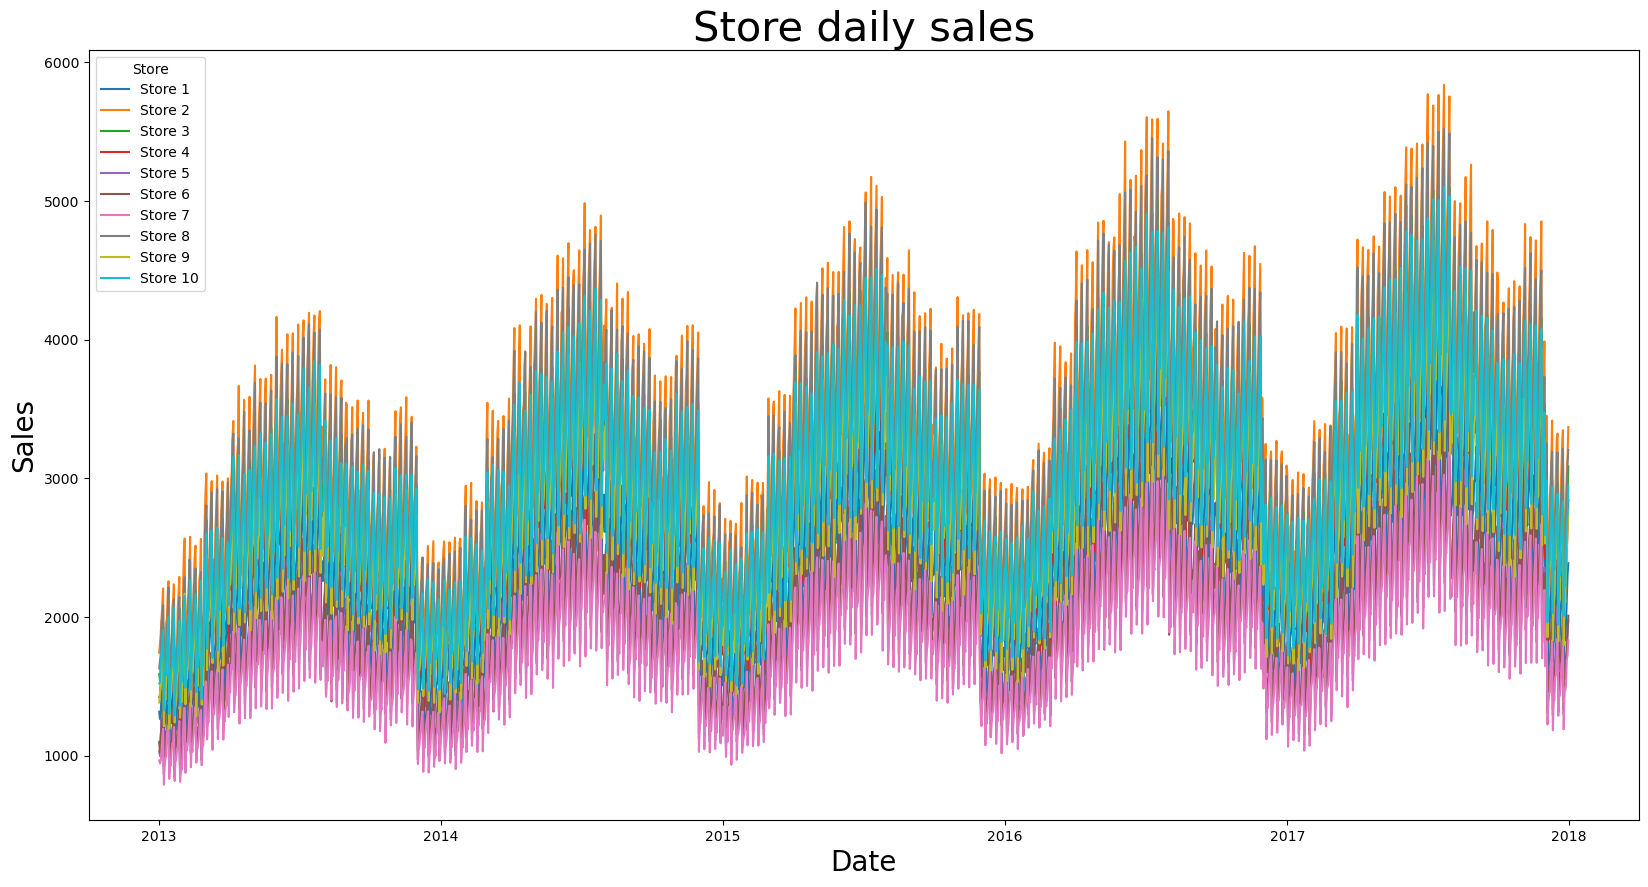

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

store_daily_sales_sc = []

for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[store_daily_sales['store'] == store]
    sns.lineplot(x='date', y='sales', data=current_store_daily_sales, label=f'Store {store}')
    
plt.title('Store daily sales', fontsize = 30)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Sales', fontsize = 20)
plt.legend(title='Store')
plt.show()

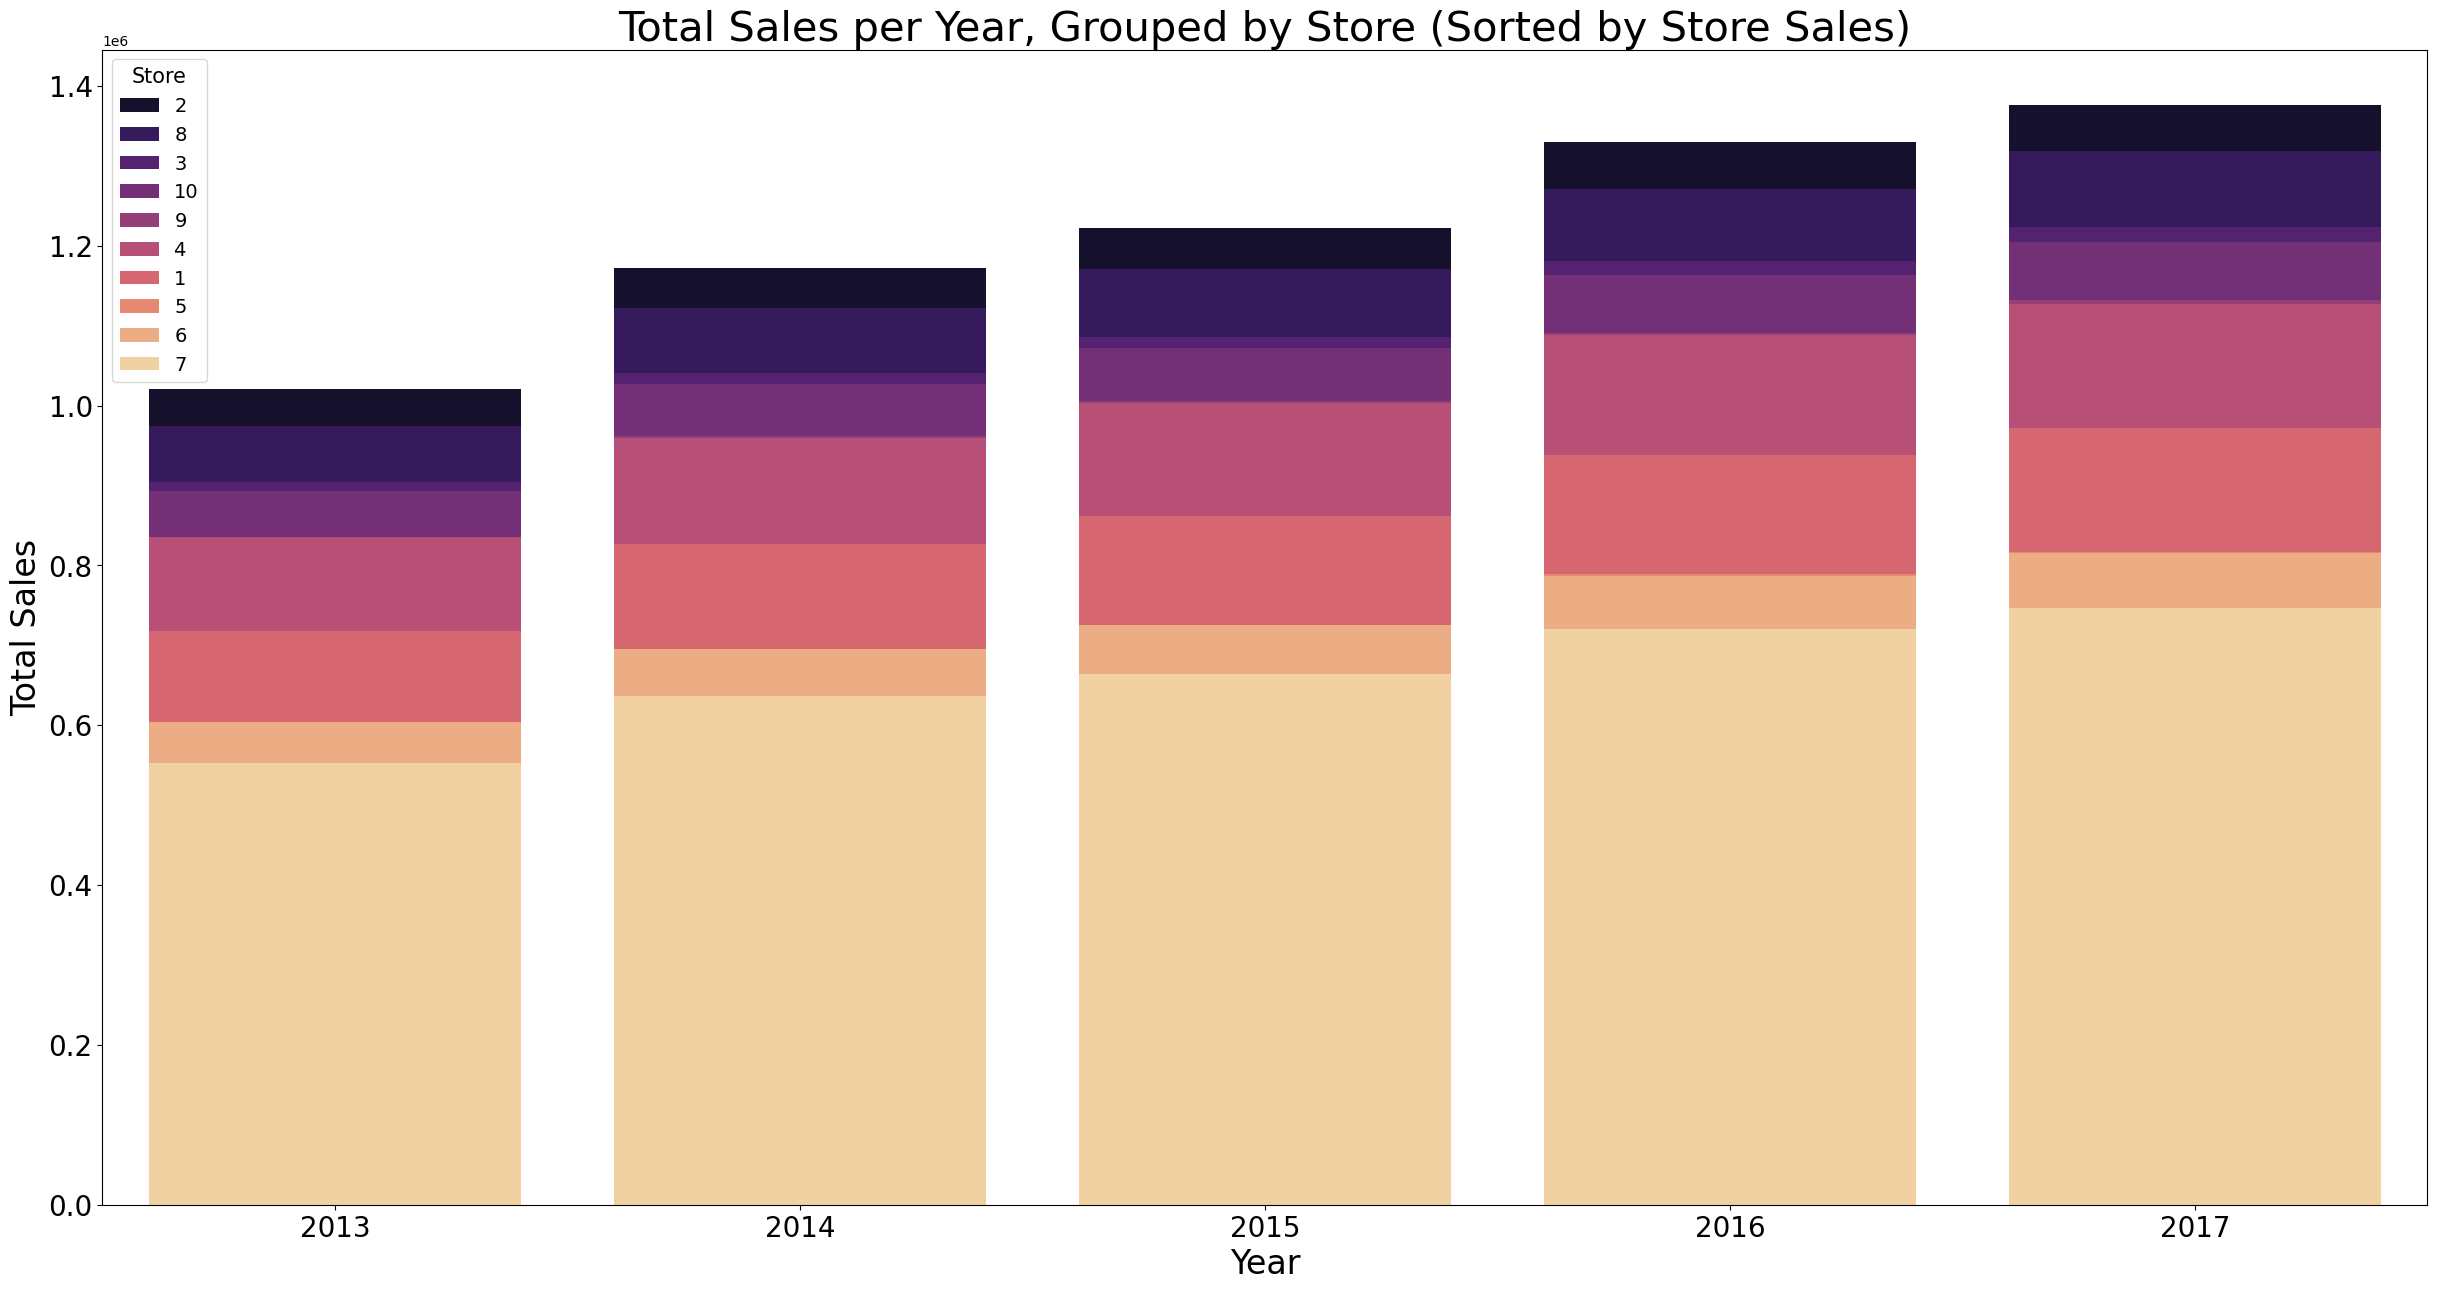

In [13]:
# Ekstrak tahun dari kolom tanggal
store_daily_sales['year'] = store_daily_sales['date'].dt.year

# Menghitung total penjualan per tahun dan per toko
yearly_sales = store_daily_sales.groupby(['year', 'store'])['sales'].sum().reset_index()

# Menghitung total penjualan per toko
total_sales_per_store = yearly_sales.groupby('store')['sales'].sum().sort_values(ascending=False).index

# Mengatur urutan toko berdasarkan total penjualan
yearly_sales['store'] = pd.Categorical(yearly_sales['store'], categories=total_sales_per_store, ordered=True)

# Mengurutkan berdasarkan urutan toko dan tahun
yearly_sales = yearly_sales.sort_values(by=['store', 'year'])

# Mengatur ukuran figur
plt.figure(figsize=(30, 15))

# Membuat bar plot
sns.barplot(x='year', y='sales', hue='store', data=yearly_sales, palette='magma', dodge=False)

# Menambahkan judul dan label sumbu
plt.title('Total Sales per Year, Grouped by Store (Sorted by Store Sales)', fontsize=30)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Total Sales', fontsize=24)

# Menambahkan ukuran teks pada sumbu x dan y
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Menampilkan legenda dengan ukuran teks lebih besar
plt.legend(title='Store', fontsize=14, title_fontsize='15')

# Menampilkan plot
plt.show()

Begitupun dengan penjualan setiap store per tahun yang mengalami peningkatan penjualan bertahap tiap tahunnya. Store 2 adalah store dengan penjualan terbanyak tiap tahunnya dan store 7 adalah store dengan penjualan paling minim diantara sepuluh store yang ada.

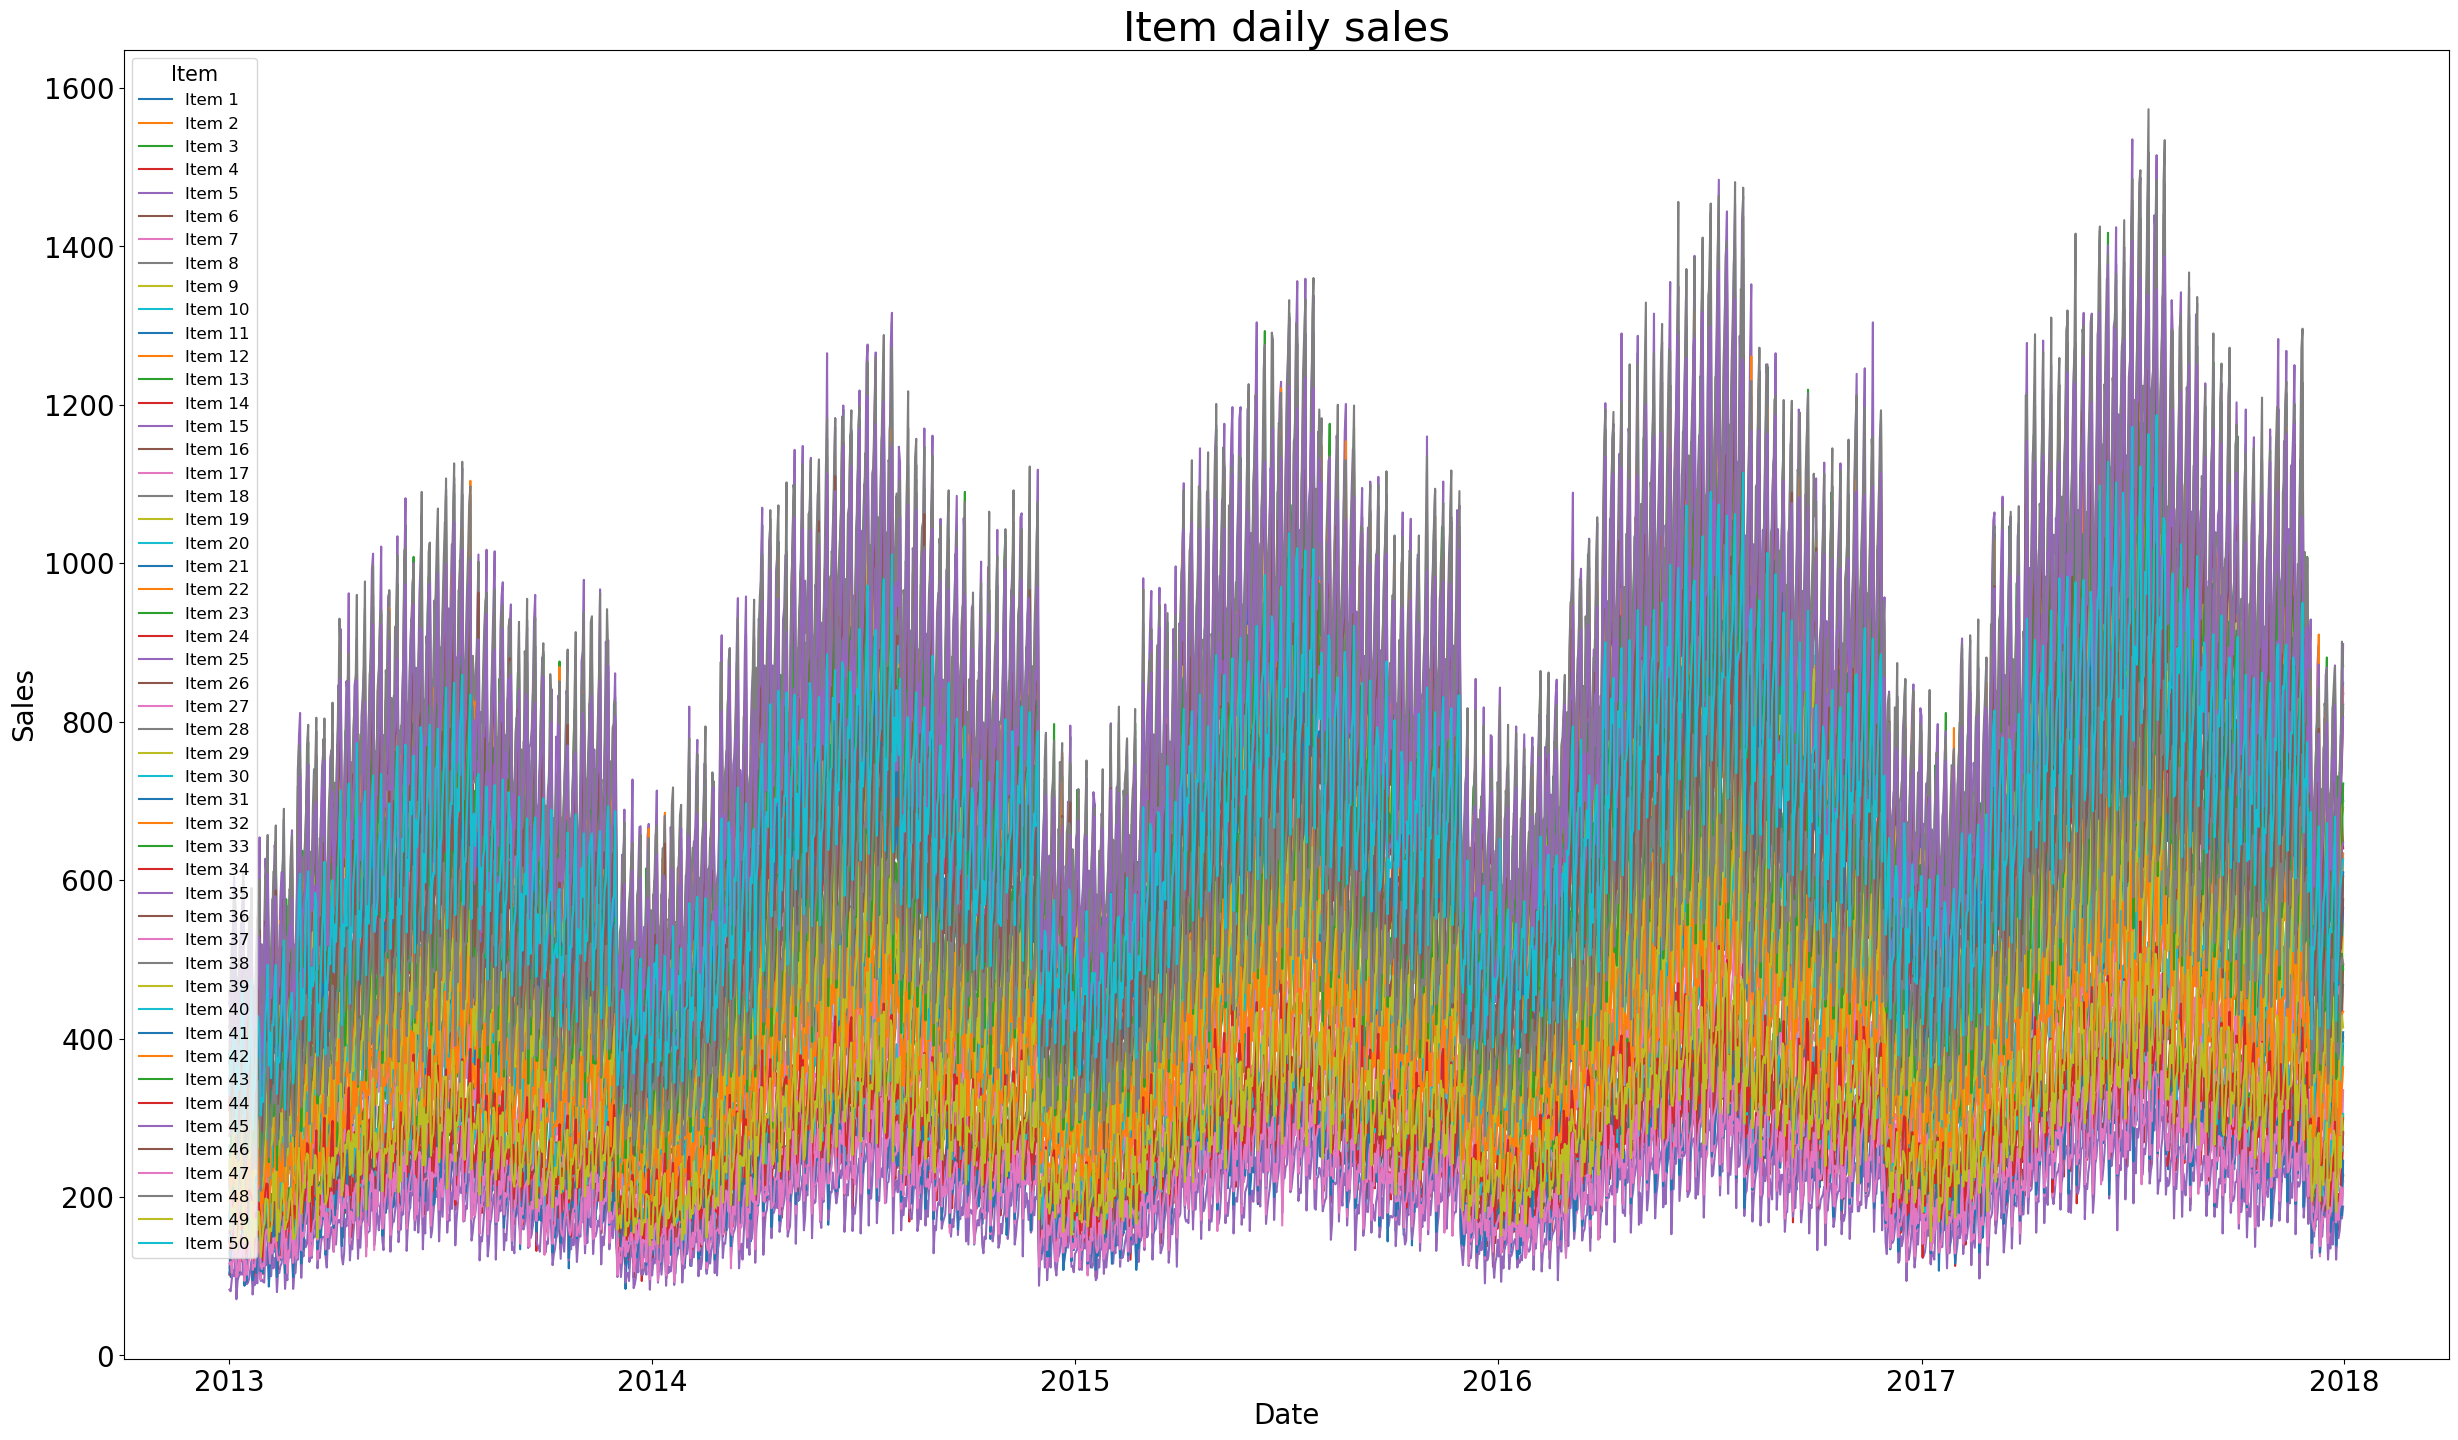

In [14]:
# Mengatur ukuran figur
plt.figure(figsize=(30, 17))

item_daily_sales_sc = []

for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[item_daily_sales['item'] == item]
    sns.lineplot(x='date', y='sales', data=current_item_daily_sales, label=f'Item {item}')

plt.title('Item daily sales', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title='Item', fontsize=12, title_fontsize='15')
plt.show()

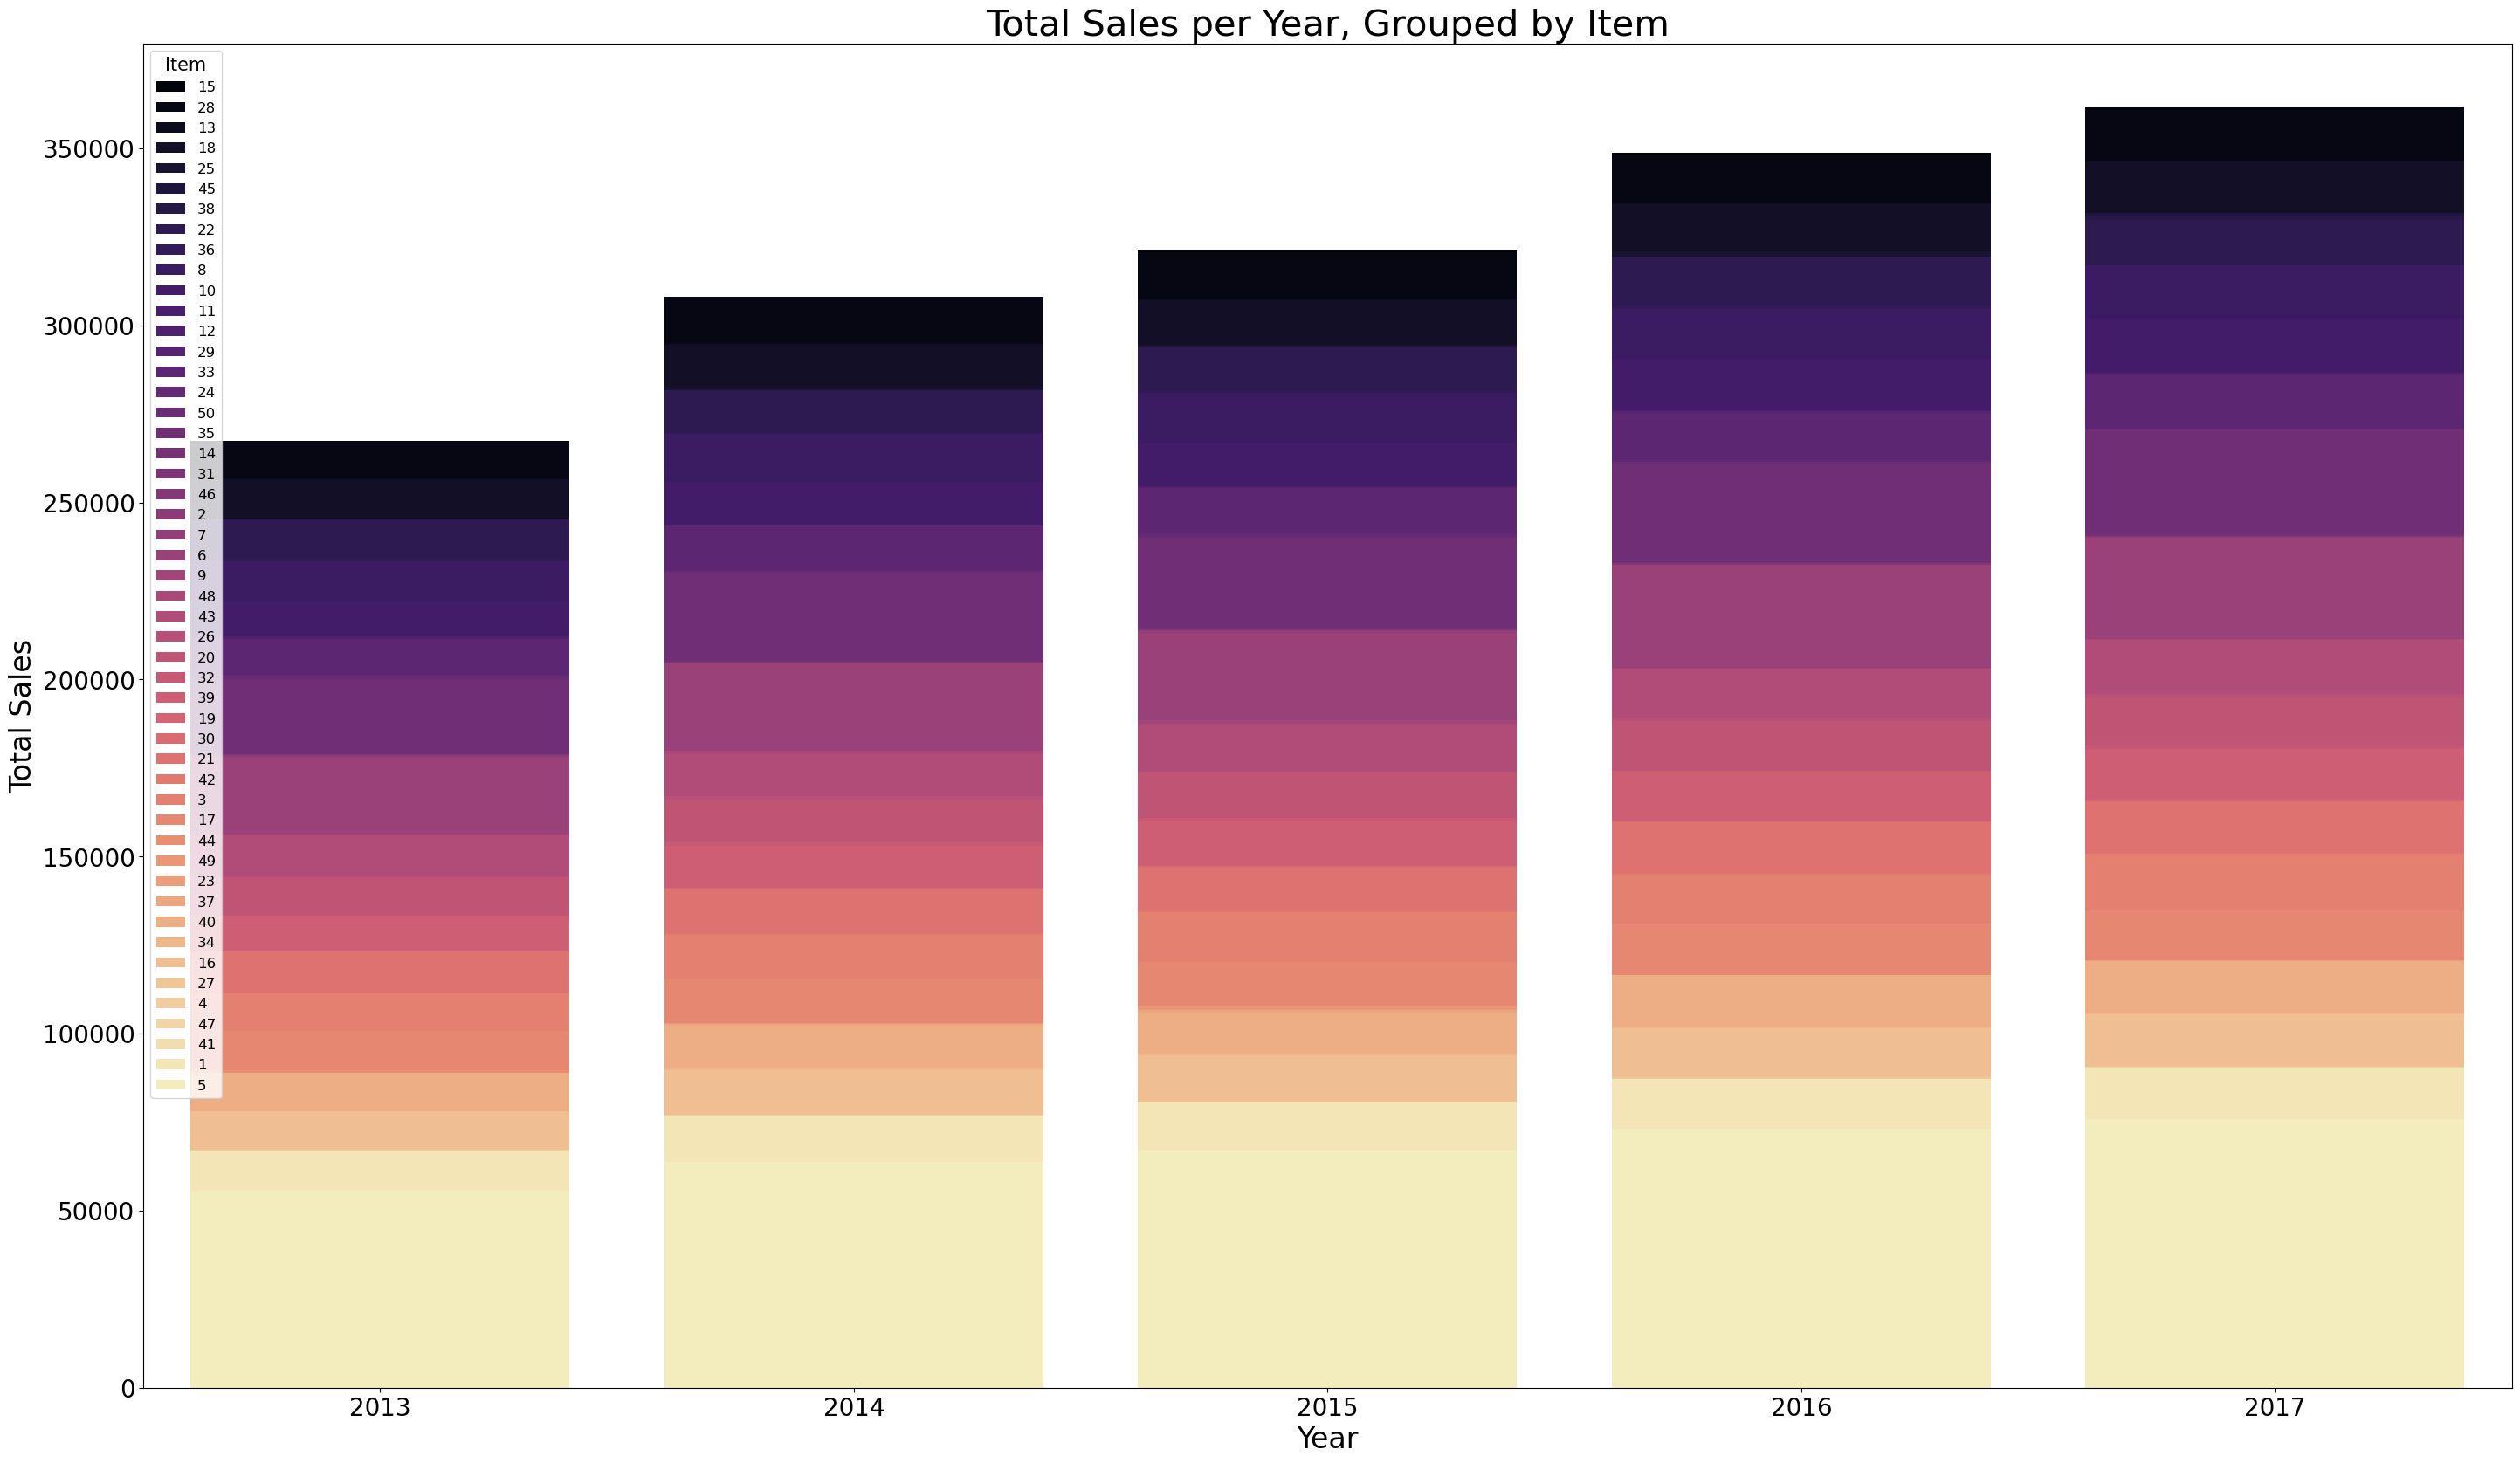

In [15]:
# Ekstrak tahun dari kolom tanggal
item_daily_sales['year'] = item_daily_sales['date'].dt.year

# Menghitung total penjualan per tahun dan per toko
yearly_sales = item_daily_sales.groupby(['year', 'item'])['sales'].sum().reset_index()

# Menghitung total penjualan per toko
total_sales_per_item = yearly_sales.groupby('item')['sales'].sum().sort_values(ascending=False).index

# Mengatur urutan toko berdasarkan total penjualan
yearly_sales['item'] = pd.Categorical(yearly_sales['item'], categories=total_sales_per_item, ordered=True)

# Mengurutkan berdasarkan urutan toko dan tahun
yearly_sales = yearly_sales.sort_values(by=['item', 'year'])

# Mengatur ukuran figur
plt.figure(figsize=(35, 20))

# Membuat bar plot
sns.barplot(x='year', y='sales', hue='item', data=yearly_sales, palette='magma', dodge=False)

# Menambahkan judul dan label sumbu
plt.title('Total Sales per Year, Grouped by Item', fontsize=30)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Total Sales', fontsize=24)

# Menambahkan ukuran teks pada sumbu x dan y
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Menampilkan legenda dengan ukuran teks lebih besar
plt.legend(title='Item', fontsize=12, title_fontsize='15')

# Menampilkan plot
plt.show()

sama halnya dengan penjualan per tahun dan penjualan setiap store per tahun yang mengalami peningkatan penjualan bertahap tiap tahunnya. Item 15 adalah item dengan penjualan terbanyak tiap tahunnya dan item 5 adalah item dengan penjualan paling minim diantara 50 item yang tersedia.

# Preprocessing

## Sub-sample train set to get only the last year of data and reduce training time

In [16]:
train = train[(train['date'] >= '2017-01-01')]

## Susun ulang dataset sehingga kita dapat menerapkan metode shift¶

In [17]:
# Mengurutkan data train berdasarkan kolom 'date', kemudian mengelompokkan berdasarkan kombinasi 'item', 'store', dan 'date'
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)

# Melakukan agregasi dengan menghitung rata-rata 'sales' untuk setiap kelompok item, store, dan date
train_gp = train_gp.agg({'sales': ['mean']})

# Meratakan nama kolom setelah aggregasi untuk mempermudah pengelolaan data
train_gp.columns = ['item', 'store', 'date', 'sales']

# Menampilkan DataFrame train_gp
train_gp

item  store       date  sales
0          1      1 2017-01-01   19.0
1          1      1 2017-01-02   15.0
2          1      1 2017-01-03   10.0
3          1      1 2017-01-04   16.0
4          1      1 2017-01-05   14.0
...      ...    ...        ...    ...
182495    50     10 2017-12-27   63.0
182496    50     10 2017-12-28   59.0
182497    50     10 2017-12-29   74.0
182498    50     10 2017-12-30   62.0
182499    50     10 2017-12-31   82.0

[182500 rows x 4 columns]

## Ubah data menjadi masalah deret waktu

In [18]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    # Inisialisasi list kosong untuk menyimpan kolom-kolom hasil transformasi dan nama-nama kolom baru
    cols = []
    names = []
    
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        # Menambahkan versi data yang digeser sebanyak i timestep ke dalam list cols
        cols.append(data.shift(i))
        # Menambahkan nama kolom baru untuk setiap kolom dalam data yang digeser
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    
    # Current timestep (t=0)
    cols.append(data)  # Menambahkan versi data pada timestep saat ini (t=0) ke dalam list cols
    names += [('%s(t)' % (col)) for col in data.columns]  # Menambahkan nama kolom baru untuk setiap kolom pada timestep saat ini
    
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))  # Menambahkan versi data yang digeser mundur sebanyak lag timestep ke dalam list cols
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]  # Menambahkan nama kolom baru untuk setiap kolom pada timestep ke depan sebanyak lag
    
    # Menggabungkan semua kolom dari list cols menjadi satu DataFrame dengan menyambungkan secara berdampingan (axis=1)
    agg = pd.concat(cols, axis=1)
    agg.columns = names  # Mengatur nama kolom DataFrame agg sesuai dengan names
    
    # Jika dropnan bernilai True, maka menghapus baris-baris dengan nilai NaN dari DataFrame agg
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg  # Mengembalikan DataFrame agg yang merupakan dataset supervised learning yang telah diubah dari data time series input

## menggunakan catatan waktu saat ini dan 29 hari terakhir untuk memperkirakan 90 hari ke depan

In [19]:
window = 29  # Menetapkan panjang jendela waktu (window size) menjadi 29
lag = lag_size  # Menetapkan jumlah lag dengan nilai lag_size yang telah ditentukan sebelumnya

# Mengubah data deret waktu menjadi format yang diawasi dengan menghapus kolom 'date' dan menggunakan panjang jendela waktu 29 serta lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)  

series.index = train_gp['date'].iloc[window:-lag]  # Mengatur indeks kembali ke 'date' setelah transformasi
series 

item(t-29)  store(t-29)  sales(t-29)  item(t-28)  store(t-28)  \
date                                                                        
2017-01-30         1.0          1.0         19.0         1.0          1.0   
2017-01-31         1.0          1.0         15.0         1.0          1.0   
2017-02-01         1.0          1.0         10.0         1.0          1.0   
2017-02-02         1.0          1.0         16.0         1.0          1.0   
2017-02-03         1.0          1.0         14.0         1.0          1.0   
...                ...          ...          ...         ...          ...   
2017-09-28        50.0         10.0         79.0        50.0         10.0   
2017-09-29        50.0         10.0         89.0        50.0         10.0   
2017-09-30        50.0         10.0         96.0        50.0         10.0   
2017-10-01        50.0         10.0         92.0        50.0         10.0   
2017-10-02        50.0         10.0        102.0        50.0         10.0   

            sales(t-28)  item(t-27)  store(t-27)  sales(t-27)  item(t-26)  \
date                                                                        
2017-01-30         15.0         1.0          1.0         10.0         1.0   
2017-01-31         10.0         1.0          1.0         16.0         1.0   
2017-02-01         16.0         1.0          1.0         14.0         1.0   
2017-02-02         14.0         1.0          1.0         24.0         1.0   
2017-02-03         24.0         1.0          1.0         14.0         1.0   
...                 ...         ...          ...          ...         ...   
2017-09-28         89.0        50.0         10.0         96.0        50.0   
2017-09-29         96.0        50.0         10.0         92.0        50.0   
2017-09-30         92.0        50.0         10.0        102.0        50.0   
2017-10-01        102.0        50.0         10.0         60.0        50.0   
2017-10-02         60.0        50.0         10.0         81.0        50.0   

            ...  sales(t-2)  item(t-1)  store(t-1)  sales(t-1)  item(t)  \
date        ...                                                           
2017-01-30  ...        16.0        1.0         1.0        24.0        1   
2017-01-31  ...        24.0        1.0         1.0         9.0        1   
2017-02-01  ...         9.0        1.0         1.0        17.0        1   
2017-02-02  ...        17.0        1.0         1.0        15.0        1   
2017-02-03  ...        15.0        1.0         1.0        17.0        1   
...         ...         ...        ...         ...         ...      ...   
2017-09-28  ...        79.0       50.0        10.0        80.0       50   
2017-09-29  ...        80.0       50.0        10.0        82.0       50   
2017-09-30  ...        82.0       50.0        10.0        90.0       50   
2017-10-01  ...        90.0       50.0        10.0       103.0       50   
2017-10-02  ...       103.0       50.0        10.0        99.0       50   

            store(t)  sales(t)  item(t+90)  store(t+90)  sales(t+90)  
date                                                                  
2017-01-30         1       9.0         1.0          1.0         33.0  
2017-01-31         1      17.0         1.0          1.0         15.0  
2017-02-01         1      15.0         1.0          1.0         21.0  
2017-02-02         1      17.0         1.0          1.0         29.0  
2017-02-03         1      24.0         1.0          1.0         19.0  
...              ...       ...         ...          ...          ...  
2017-09-28        10      82.0        50.0         10.0         63.0  
2017-09-29        10      90.0        50.0         10.0         59.0  
2017-09-30        10     103.0        50.0         10.0         74.0  
2017-10-01        10      99.0        50.0         10.0         62.0  
2017-10-02        10      71.0        50.0         10.0         82.0  

[182381 rows x 93 columns]

## Drop baris dengan nilai item atau penyimpanan yang berbeda dari kolom yang digeser

In [20]:
last_item = 'item(t-%d)' % window  # Membuat nama kolom untuk item pada t-waktu sebelumnya (29 langkah sebelumnya)
last_store = 'store(t-%d)' % window  # Membuat nama kolom untuk store pada t-waktu sebelumnya (29 langkah sebelumnya)
series = series[(series['store(t)'] == series[last_store])]  # Memfilter baris di mana nilai 'store(t)' sama dengan 'store(t-29)'
series = series[(series['item(t)'] == series[last_item])]  # Memfilter baris di mana nilai 'item(t)' sama dengan 'item(t-29)'

## Hapus kolom yang tidak diinginkan

In [21]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]  # Membuat daftar nama kolom yang akan dihapus untuk prediksi masa depan (t+lag) dari item dan store
for i in range(window, 0, -1):  # Melakukan iterasi dari window (29) hingga 1 secara menurun
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]  # Menambahkan nama kolom untuk t-waktu sebelumnya (t-i) dari item dan store ke dalam daftar kolom yang akan dihapus
series.drop(columns_to_drop, axis=1, inplace=True)  # Menghapus kolom-kolom yang ada dalam daftar columns_to_drop dari DataFrame series
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)  # Menghapus kolom 'item(t)' dan 'store(t)' dari DataFrame series

## Train/validation split¶

In [22]:
# Label
labels_col = 'sales(t+%d)' % lag_size  # Membuat nama kolom untuk label yang akan diprediksi (sales pada t+lag_size)
labels = series[labels_col]  # Menyimpan nilai-nilai dari kolom label tersebut ke dalam variabel labels
series = series.drop(labels_col, axis=1)  # Menghapus kolom label dari DataFrame series

# Membagi data menjadi set pelatihan dan validasi dengan proporsi 60% pelatihan dan 40% validasi, menggunakan random_state untuk hasil yang konsisten
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0) 

print('Train set shape', X_train.shape)  # Mencetak bentuk (shape) dari set pelatihan
print('Validation set shape', X_valid.shape)  # Mencetak bentuk (shape) dari set validasi
X_train.head()  # Menampilkan beberapa baris pertama dari set pelatihan

Train set shape (100746, 30)
Validation set shape (67164, 30)


sales(t-29)  sales(t-28)  sales(t-27)  sales(t-26)  sales(t-25)  \
date                                                                          
2017-07-06         97.0        111.0         90.0        115.0        123.0   
2017-05-31         38.0         43.0         43.0         55.0         47.0   
2017-05-04         55.0         45.0         41.0         46.0         47.0   
2017-10-01        139.0        157.0         85.0         99.0        136.0   
2017-12-13         86.0         58.0         88.0         87.0        114.0   

            sales(t-24)  sales(t-23)  sales(t-22)  sales(t-21)  sales(t-20)  \
date                                                                          
2017-07-06         70.0         99.0         74.0        107.0        108.0   
2017-05-31         51.0         38.0         41.0         37.0         59.0   
2017-05-04         36.0         30.0         46.0         41.0         42.0   
2017-10-01        110.0        121.0        123.0        147.0         91.0   
2017-12-13        113.0         64.0         76.0         87.0         81.0   

            ...  sales(t-9)  sales(t-8)  sales(t-7)  sales(t-6)  sales(t-5)  \
date        ...                                                               
2017-07-06  ...        85.0        95.0       123.0       109.0       127.0   
2017-05-31  ...        41.0        38.0        38.0        53.0        53.0   
2017-05-04  ...        38.0        36.0        40.0        50.0        44.0   
2017-10-01  ...       130.0       128.0       128.0        95.0       116.0   
2017-12-13  ...        55.0        66.0        59.0        53.0        63.0   

            sales(t-4)  sales(t-3)  sales(t-2)  sales(t-1)  sales(t)  
date                                                                  
2017-07-06       132.0        87.0       101.0       102.0     114.0  
2017-05-31        45.0        44.0        24.0        30.0      37.0  
2017-05-04        44.0        40.0        38.0        50.0      49.0  
2017-10-01       110.0       117.0       118.0       129.0     132.0  
2017-12-13        59.0        77.0        39.0        56.0      62.0  

[5 rows x 30 columns]

# MLP for Time Series Forecasting
* Pertama kita akan menggunakan model Multilayer Perceptron atau model MLP, disini model kita akan memiliki fitur input yang sama dengan ukuran window.
* Masalahnya dengan model MLP adalah model tidak mengambil input sebagai data yang diurutkan, jadi untuk model hanya menerima input dan tidak memperlakukannya sebagai data yang diurutkan, itu mungkin menjadi masalah karena model tidak akan menerima input. melihat data dengan pola urutan yang dimilikinya.
* Bentuk masukan [sampel, langkah waktu].



In [23]:
epochs = 40  # Menetapkan jumlah epoch (putaran pelatihan lengkap pada dataset) menjadi 40
batch = 256  # Menetapkan ukuran batch (jumlah sampel yang diproses sebelum memperbarui model) menjadi 256
lr = 0.0003  # Menetapkan nilai learning rate (laju pembelajaran) menjadi 0.0003
adam = optimizers.Adam(lr)  # Membuat optimizer Adam dengan learning rate yang telah ditentukan

In [24]:
model_mlp = Sequential()  # Membuat model Sequential untuk menambahkan lapisan secara berurutan

# Menambahkan lapisan Dense pertama dengan 100 unit neuron, fungsi aktivasi ReLU,
# dan input_dim yang sesuai dengan jumlah fitur dari X_train
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))

# Menambahkan lapisan Dense kedua dengan 1 unit neuron tanpa fungsi aktivasi khusus (linier)
model_mlp.add(Dense(1))

# Mengonfigurasi model dengan loss function MSE (Mean Squared Error) untuk masalah regresi,
# dan optimizer 'adam' yang telah sebelumnya didefinisikan dengan learning rate yang sudah ditentukan
model_mlp.compile(loss='mse', optimizer=adam)

# Menampilkan ringkasan dari arsitektur model yang telah dibuat, termasuk jumlah parameter yang dapat di-train
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)               │      3,100 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1)                 │        101 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 12s - 4ms/step - loss: 423.5597 - val_loss: 384.6353
Epoch 2/40
3149/3149 - 10s - 3ms/step - loss: 377.8419 - val_loss: 363.7979
Epoch 3/40
3149/3149 - 10s - 3ms/step - loss: 361.9565 - val_loss: 380.1796
Epoch 4/40
3149/3149 - 10s - 3ms/step - loss: 357.6012 - val_loss: 362.8230
Epoch 5/40
3149/3149 - 12s - 4ms/step - loss: 354.9757 - val_loss: 353.0300
Epoch 6/40
3149/3149 - 19s - 6ms/step - loss: 353.1469 - val_loss: 356.1962
Epoch 7/40
3149/3149 - 9s - 3ms/step - loss: 351.7210 - val_loss: 349.0635
Epoch 8/40
3149/3149 - 8s - 3ms/step - loss: 351.6498 - val_loss: 348.1176
Epoch 9/40
3149/3149 - 12s - 4ms/step - loss: 350.3787 - val_loss: 348.1100
Epoch 10/40
3149/3149 - 10s - 3ms/step - loss: 349.9913 - val_loss: 347.2490
Epoch 11/40
3149/3149 - 11s - 4ms/step - loss: 347.9995 - val_loss: 348.3834
Epoch 12/40
3149/3149 - 11s - 4ms/step - loss: 347.4090 - val_loss: 347.5185
Epoch 13/40
3149/3149 - 14s - 5ms/step - loss: 347.3236 - val_loss: 347.8203
Epoch 14/4

In [26]:
prediction = model_mlp.predict(X_valid)

2099/2099 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [27]:
# Periksa dimensi array
print("Dimensi Y_valid:", Y_valid.shape)
print("Dimensi predictions:", prediction.shape)

Dimensi Y_valid: (67164,)
Dimensi predictions: (67164, 1)


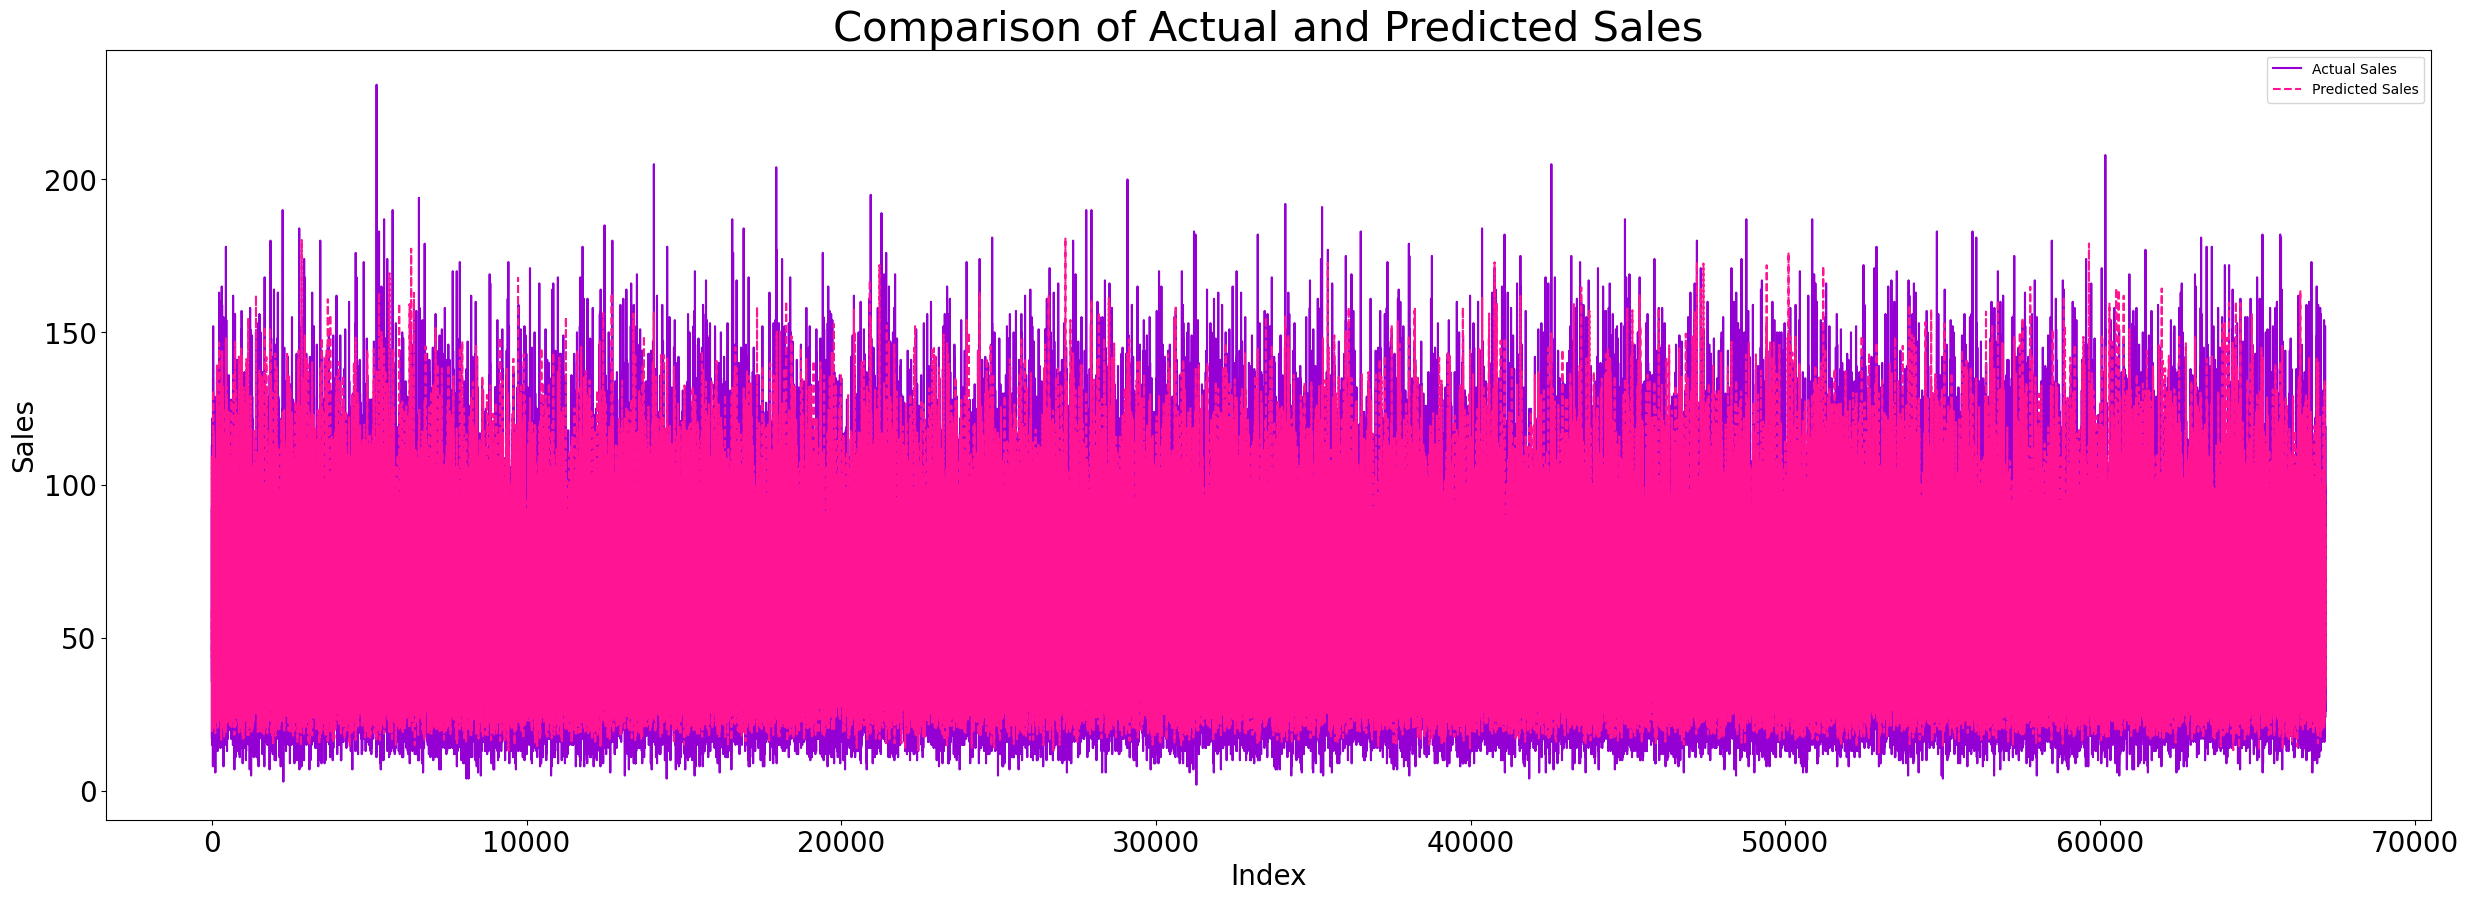

In [28]:
# Assuming predictions and Y_valid are numpy arrays or pandas Series
index = np.arange(len(Y_valid))

plt.figure(figsize=(30, 10))
plt.plot(index, Y_valid, label='Actual Sales', color='darkviolet')  # Plot actual sales in blue
plt.plot(index, prediction, label='Predicted Sales', linestyle='--', color='deeppink')  # Plot predicted sales in green

plt.title('Comparison of Actual and Predicted Sales', fontsize=30)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()

plt.show()

## Comparing models

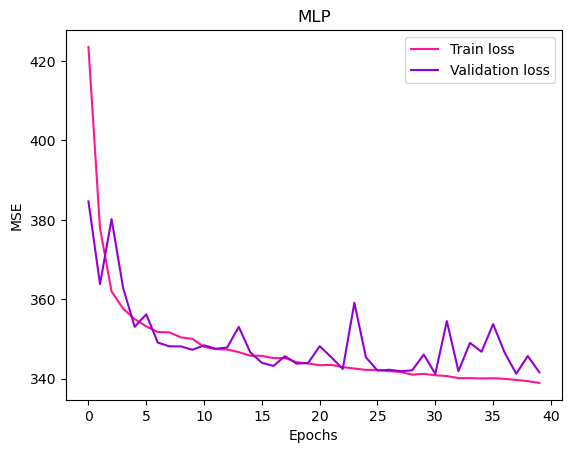

In [29]:
import matplotlib.pyplot as plt

# Assuming you have defined mlp_history somewhere above

# Create subplots and define ax1
fig, ax1 = plt.subplots()

# Plot untuk ax1 dengan warna deeppink dan darkviolet
ax1.plot(mlp_history.history['loss'], label='Train loss', color='deeppink')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss', color='darkviolet')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

# Menampilkan plot
plt.show()

# Train and validation

In [30]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

3149/3149 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Train rmse: 18.354294877472583
Validation rmse: 18.481664966856737


In [33]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_valid, mlp_valid_pred)
print(f'R-squared (R2) Score: {r2}')

R-squared (R2) Score: 0.6562919375791452


# Kesimpulan

Data penjualan item-item dari berbagai store pada tahun 2013-2017 menunjukkan pola stabil yang secara konsisten meningkat setiap tahunnya. Pola unik terlihat dalam data di mana penjualan cenderung meningkat dari awal tahun hingga pertengahan tahun, kemudian mengalami penurunan hingga akhir tahun. Hasil peramalan menggunakan data tahun 2017 dengan pembagian 60:40 menunjukkan nilai R-squared sebesar 0.6563. Ini berarti sekitar 65.63% variabilitas dalam data validasi dapat dijelaskan oleh model MLP yang digunakan. Meskipun demikian, masih terdapat sekitar 34.37% variabilitas yang tidak dapat dijelaskan oleh model ini.

Analisis ini menunjukkan bahwa model MLP cukup baik dalam memodelkan dan menjelaskan pola penjualan yang diamati, namun ada potensi untuk meningkatkan performa model agar dapat lebih baik menangkap variabilitas dalam data yang lebih besar.